In [1]:
%matplotlib inline
import GEOparse
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn import decomposition
from sklearn.feature_selection import f_classif
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import explained_variance_score, plot_roc_curve
import statsmodels.api as sm
from scipy.stats import ttest_ind
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklego.linear_model import LowessRegression

geo = "GSE152702"

In [2]:
data = GEOparse.get_GEO(geo=geo, destdir="../Dataset/Reis2020", silent=True)

In [3]:
data.metadata["platform_id"][0]

'GPL24158'

In [4]:
data.gpls[data.metadata["platform_id"][0]].table

,ID,miRNA_ID,Accession,Code Class,Target Sequence,SPOT_ID
0,hsa-let-7a-5p,hsa-let-7a-5p,MIMAT0000062,Endogenous,UGAGGUAGUAGGUUGUAUAGUU,NaN
1,hsa-let-7b-5p,hsa-let-7b-5p,MIMAT0000063,Endogenous,UGAGGUAGUAGGUUGUGUGGUU,NaN
2,hsa-let-7c-5p,hsa-let-7c-5p,MIMAT0000064,Endogenous,UGAGGUAGUAGGUUGUAUGGUU,NaN
3,hsa-let-7d-5p,hsa-let-7d-5p,MIMAT0000065,Endogenous,AGAGGUAGUAGGUUGCAUAGUU,NaN
4,hsa-let-7e-5p,hsa-let-7e-5p,MIMAT0000066,Endogenous,UGAGGUAGGAGGUUGUAUAGUU,NaN
...,...,...,...,...,...,...
815,POS_B,NaN,nmiR00809.1,Positive Control,NaN,--POS_B
816,POS_C,NaN,nmiR00811.1,Positive Control,NaN,--POS_C
817,POS_D,NaN,nmiR00822.1,Positive Control,NaN,--POS_D
818,POS_E,NaN,nmiR00801.1,Positive Control,NaN,--POS_E


In [5]:
list(data.gsms.values())[0].table

,ID_REF,VALUE
0,hsa-let-7a-5p,1.04
1,hsa-let-7b-5p,-1.31
2,hsa-let-7c-5p,1.11
3,hsa-let-7d-5p,-1.76
4,hsa-let-7e-5p,-1.52
...,...,...
798,ACTB,-9.48
799,B2M,-1.51
800,GAPDH,-4.71
801,RPL19,1.17


In [6]:
table = pd.concat((val.table.iloc[:,1:2] for val in data.gsms.values()), axis=1).transpose()
mirnas = list(data.gsms.values())[0].table.iloc[:,0]
controls = np.array(["controls" in k.metadata["title"][0] for k in list(data.gsms.values())])
table.index = list(range(len(table)))

In [7]:
table

,0,1,2,3,4,5,6,7,8,9,...,793,794,795,796,797,798,799,800,801,802
0,1.04,-1.31,1.11,-1.76,-1.52,1.32,-1.89,-1.70,-9.17,-3.39,...,1.93,-3.37,-6.68,-3.31,1.16,-9.48,-1.51,-4.71,1.17,-3.06
1,-25.66,1.34,1.71,-1.23,1.13,2.88,-5.64,1.28,1.09,2.96,...,12.53,2.98,2.06,8.72,1.62,6.22,3.52,2.13,2.24,9.45
2,2.16,3.40,105.07,22.08,33.34,32.72,18.08,13.08,260.94,164.01,...,118.01,380.26,19.36,721.79,207.61,369.51,17.94,117.92,124.09,418.90
3,2.47,23.13,54.25,41.26,38.10,37.39,19.25,4.52,69.25,187.42,...,134.86,188.45,22.13,191.56,102.89,66.96,20.50,396.96,141.81,207.60
4,5.22,2.46,2.48,2.23,-1.05,7.08,1.63,2.45,-3.62,-3.39,...,-1.01,-3.37,2.27,2.70,5.26,1.11,1.69,-1.54,1.40,-3.06
5,19.69,6.01,4.39,7.35,3.97,15.65,5.00,7.70,1.08,-3.39,...,-2.78,-3.37,9.86,1.64,3.80,2.95,4.75,1.63,-1.83,-3.06
6,3.79,2.14,1.06,1.72,-1.10,-1.21,-1.13,1.10,-2.27,-1.15,...,-4.23,-3.03,1.65,-2.98,2.46,3.48,2.57,-4.24,2.89,-2.75
7,8.14,6.47,5.00,3.48,3.33,7.68,1.67,3.37,-1.05,-2.03,...,1.51,-2.02,4.31,-1.99,4.93,1.28,2.97,-2.25,2.70,3.41
8,-72.21,-2.84,-6.39,-5.64,-4.68,-2.21,-39.69,-39.40,-2.57,1.05,...,-1.32,1.06,1.14,1.07,-1.50,-2.31,-8.69,-1.32,-1.09,1.16
9,-1.24,2.09,1.44,-2.83,-9.89,-10.08,-2.23,-2.73,-1.56,-2.01,...,-2.79,-2.00,-1.62,1.26,1.50,5.42,1.01,3.39,3.19,-1.82


### Remove outliers

In [8]:
outliers = [ 2,  3, 20]
table = table.drop(index=outliers)
controls = np.delete(controls, outliers)

In [9]:
np.mean(table)

0     -22.660000
1       0.893810
2      -0.316905
3      -3.843571
4      -2.250476
         ...    
798    -0.115952
799    -4.415000
800     0.026190
801     1.619762
802    -0.284762
Length: 803, dtype: float64

In [10]:
def get_means_and_variances(table):
    return np.mean(table), np.var(table, ddof=1)

In [11]:
def mean_variance_plot(table):
    means, variances = get_means_and_variances(table)
    plt.scatter(means, variances)
    plt.xlabel("mean")
    plt.ylabel("variance")
    plt.plot()

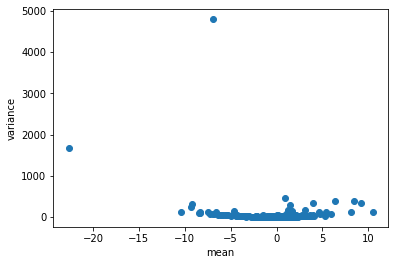

In [12]:
mean_variance_plot(table)

### Log transformation

In [13]:
log_table = table#np.log2(table - table.min().min() + 0.001)

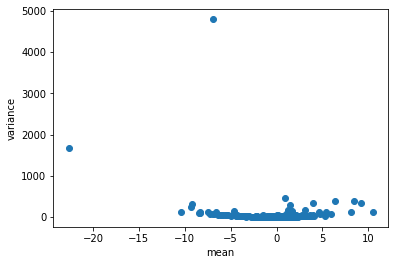

In [14]:
mean_variance_plot(log_table)

In [15]:
norm_log_table = log_table #- np.mean(log_table)

In [16]:
#norm_log_table /= np.sqrt(np.mean(np.var(norm_log_table, ddof=1)))

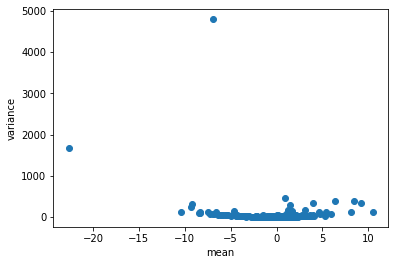

In [17]:
mean_variance_plot(norm_log_table)

### PCA

In [18]:
pca = decomposition.PCA(n_components=2)

In [19]:
pca.fit(norm_log_table)

PCA(n_components=2)

In [20]:
components = pca.transform(norm_log_table)

In [21]:
components

array([[  33.62310536,  -73.38319164],
       [  -0.38250993,  103.68871923],
       [  34.72470094,  -62.75024924],
       [  31.16189542,  -62.6561797 ],
       [  38.7072763 ,  -54.35768006],
       [   7.60380567,  -45.53583583],
       [  53.56110012,   83.22951877],
       [ 187.0320827 ,   70.56297559],
       [ -57.98918399,  -13.86517412],
       [  36.8154534 ,  -62.50576373],
       [ -49.13583716,   56.30096043],
       [  13.9042994 ,  111.6948656 ],
       [ -39.54000064,  135.62484968],
       [ -85.26169103,    2.31844675],
       [-111.8153774 ,   13.74216679],
       [-164.99964449,    2.17062496],
       [-101.58398066,  -30.02348717],
       [ -71.64049024,   24.57658795],
       [ -89.07903691,   -4.19061625],
       [ -13.54687062,  -35.36241598],
       [  10.35606722,  108.8252587 ],
       [  -8.0882487 ,   21.61486633],
       [ -71.88188395,  -11.78912266],
       [ -16.15728755,  -54.94693182],
       [ -44.77878064,   50.92012355],
       [ -78.36557152,   

In [22]:
list(data.gsms.values())[-1].metadata

{'title': ['Pool 7 controls'],
 'geo_accession': ['GSM4624108'],
 'status': ['Public on Sep 08 2020'],
 'submission_date': ['Jun 17 2020'],
 'last_update_date': ['Sep 08 2020'],
 'type': ['RNA'],
 'channel_count': ['1'],
 'source_name_ch1': ['Plasma samples from non-diseased individuals'],
 'organism_ch1': ['Homo sapiens'],
 'taxid_ch1': ['9606'],
 'characteristics_ch1': ['gender: Paired by sex',
  'age: Paired by age',
  'histology: Not aplicable',
  'tissue: Plasma',
  'smoking: Current',
  'Stage: Not aplicable'],
 'treatment_protocol_ch1': ['5ÂµL of a 200pM solution of two exogenous synthetic spike-in controls (ath-miR-159a and cel-miR-248; Integrated DNA Technologies - IDT, Coralville, IA, USA), were added after sample lysis, according to the Nanostring protocol'],
 'molecule_ch1': ['total RNA'],
 'extract_protocol_ch1': ['Two hundred microliters (200ÂµL) of plasma were used for RNA extraction with the miRNeasy Serum/Plasma Kit (Qiagen, Canada), following the manufacturerâ€™s prot

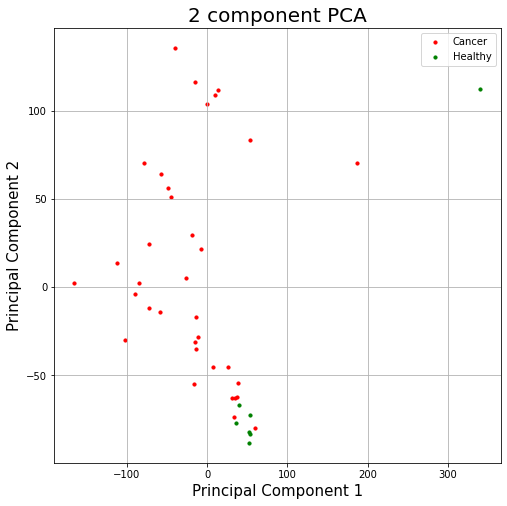

In [23]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1)

ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = ['Cancer', 'Healthy']
colors = ['r', 'g']
ax.scatter(components[controls == False, 0], components[controls == False, 1], c = 'r', s = 10)
ax.scatter(components[controls == True, 0], components[controls == True, 1], c = 'g', s = 10)
ax.legend(targets)
ax.grid()

In [24]:
outliers = np.nonzero(components[:,0] > 25)
outliers

(array([ 0,  2,  3,  4,  6,  7,  9, 27, 32, 35, 36, 37, 38, 39, 40, 41],
       dtype=int64),)

In [25]:
components2 = components[components[:,0] < 20, :]
controls2 = controls[components[:,0] < 20]

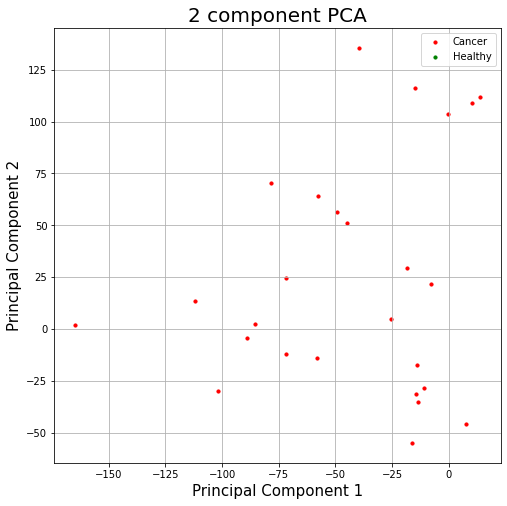

In [26]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1)

ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = ['Cancer', 'Healthy']
colors = ['r', 'g']
ax.scatter(components2[controls2 == False, 0], components2[controls2 == False, 1], c = 'r', s = 10)
ax.scatter(components2[controls2 == True, 0], components2[controls2 == True, 1], c = 'g', s = 10)
ax.legend(targets)
ax.grid()

### Logistic Regression

In [27]:
X_train, X_test, y_train, y_test = train_test_split(norm_log_table, controls, test_size=0.33, random_state=42)

In [28]:
model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

C:\Users\olefr\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


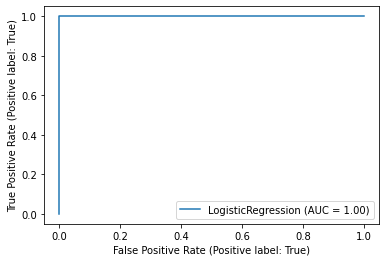

In [29]:
plot_roc_curve(model, X_test, y_test)

### XGBoost

In [30]:
model = XGBClassifier(use_label_encoder=False)
model.fit(X_train, y_train)

[20:19:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=16,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

C:\Users\olefr\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


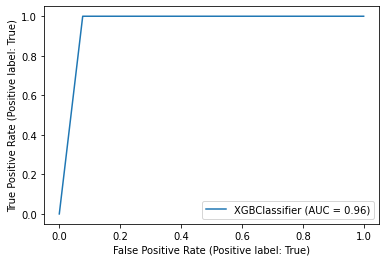

In [31]:
plot_roc_curve(model, X_test, y_test)

### Export data

In [32]:
lookup_table = data.gpls["GPL24158"].table.set_index("ID")
lookup_table.head()

,miRNA_ID,Accession,Code Class,Target Sequence,SPOT_ID
ID,,,,,
hsa-let-7a-5p,hsa-let-7a-5p,MIMAT0000062,Endogenous,UGAGGUAGUAGGUUGUAUAGUU,NaN
hsa-let-7b-5p,hsa-let-7b-5p,MIMAT0000063,Endogenous,UGAGGUAGUAGGUUGUGUGGUU,NaN
hsa-let-7c-5p,hsa-let-7c-5p,MIMAT0000064,Endogenous,UGAGGUAGUAGGUUGUAUGGUU,NaN
hsa-let-7d-5p,hsa-let-7d-5p,MIMAT0000065,Endogenous,AGAGGUAGUAGGUUGCAUAGUU,NaN
hsa-let-7e-5p,hsa-let-7e-5p,MIMAT0000066,Endogenous,UGAGGUAGGAGGUUGUAUAGUU,NaN


In [33]:
mask = np.array([m[:3] == "hsa" for m in mirnas])
mirnas = mirnas[mask]
norm_log_table = norm_log_table.loc[:, mask]

In [34]:
sequences = lookup_table.loc[mirnas]["Target Sequence"]

In [35]:
norm_log_table.columns = sequences
norm_log_table = norm_log_table.loc[:,~norm_log_table.columns.duplicated()]
norm_log_table["cancer"] = 1 - controls
norm_log_table.head()

Target Sequence,UGAGGUAGUAGGUUGUAUAGUU,UGAGGUAGUAGGUUGUGUGGUU,UGAGGUAGUAGGUUGUAUGGUU,AGAGGUAGUAGGUUGCAUAGUU,UGAGGUAGGAGGUUGUAUAGUU,UGAGGUAGUAGAUUGUAUAGUU,UGAGGUAGUAGUUUGUACAGUU,UGAGGUAGUAGUUUGUGCUGUU,UGGAAUGUAAAGAAGUAUGUAU,ACAUACUUCUUUAUAUGCCCAU,...,CACAUGGCCGAAACAGAGAAGU,UCUUCUCUGUUUUGGCCAUGUG,AAAUUAUUGUACAUCGGAUGAG,UUCAACGGGUAUUUAUUGAGCA,UUUGGCACUAGCACAUUUUUGCU,CUAUACAACUUACUACUUUCCC,UGAGGUAGUAAGUUGUAUUGUU,AACCCGUAGAUCCGAUCUUGUG,CACCCGUAGAACCGACCUUGCG,cancer
0,1.04,-1.31,1.11,-1.76,-1.52,1.32,-1.89,-1.70,-9.17,-3.39,...,-3.07,-3.56,1.44,-5.29,1.93,-3.37,-6.68,-3.31,1.16,1
1,-25.66,1.34,1.71,-1.23,1.13,2.88,-5.64,1.28,1.09,2.96,...,3.27,2.81,-1.88,1.90,12.53,2.98,2.06,8.72,1.62,1
4,5.22,2.46,2.48,2.23,-1.05,7.08,1.63,2.45,-3.62,-3.39,...,-3.07,-1.78,-1.19,-5.29,-1.01,-3.37,2.27,2.70,5.26,1
5,19.69,6.01,4.39,7.35,3.97,15.65,5.00,7.70,1.08,-3.39,...,-3.07,1.11,-1.38,-1.34,-2.78,-3.37,9.86,1.64,3.80,1
6,3.79,2.14,1.06,1.72,-1.10,-1.21,-1.13,1.10,-2.27,-1.15,...,-2.76,-3.21,-1.16,1.61,-4.23,-3.03,1.65,-2.98,2.46,1


In [36]:
norm_log_table.to_csv("../TransformedData/Reis2020_raw.csv", index=False)